# SESSION: Simulating time series signals and noise #3.32 and 3.33. Project 1-1: Channel-level EEG data

COURSE: Neural signal processing and analysis: Zero to hero

TEACHER: Mike X Cohen, sincxpress.com

## Instructions:

The goal of this assignment is to simulate time series data that can be used to test time-series analysis methods.

For each section below:

1. Complete the Python code
2. Put the data into the EEG structure, makign sure all the relevant fields are accurate
3. Use the function plot_simEEG to plot some data

First, import relevant libraries and initialize the attributedict structure to mimic the EEGlab data structure

In [2]:
import sys
sys.path.insert(1, '../')
import numpy as np
import matplotlib.pyplot as plt
from attributedict.collections import AttributeDict
from numpy.fft import fft, ifft
from scipy.interpolate import interp1d
from utils import *

In [3]:
EEG = AttributeDict()

## 1) pure phase-locked sine wave

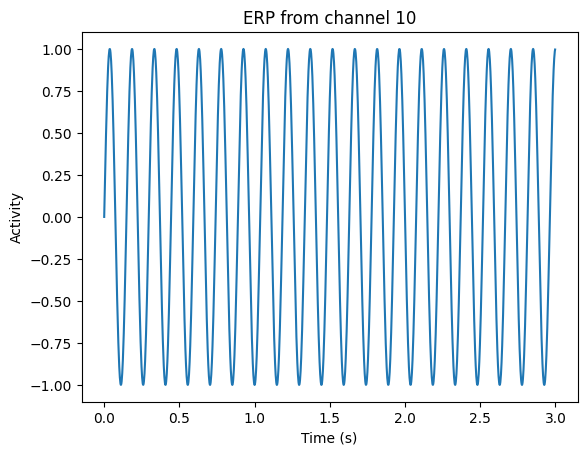

In [4]:
# parameters
EEG.srate  = 500 # sampling rate in Hz
EEG.pnts   = 1500
EEG.trials = 30
EEG.nbchan = 23

sinefreq = 6.75 # in Hz

# time vector
EEG.times = np.arange(0, EEG.pnts)/EEG.srate
EEG.data = np.zeros((EEG.nbchan, EEG.pnts, EEG.trials))

for chani in range(EEG.nbchan):
    for triali in range(EEG.trials):
        EEG.data[chani, :, triali] = np.sin(2*np.pi*sinefreq*EEG.times)
        
# plot an ERP from one channel
plt.plot(EEG.times, np.mean(EEG.data[10, :,:], axis=1))
plt.xlabel('Time (s)')
plt.ylabel('Activity')
plt.title('ERP from channel 10')
plt.show()

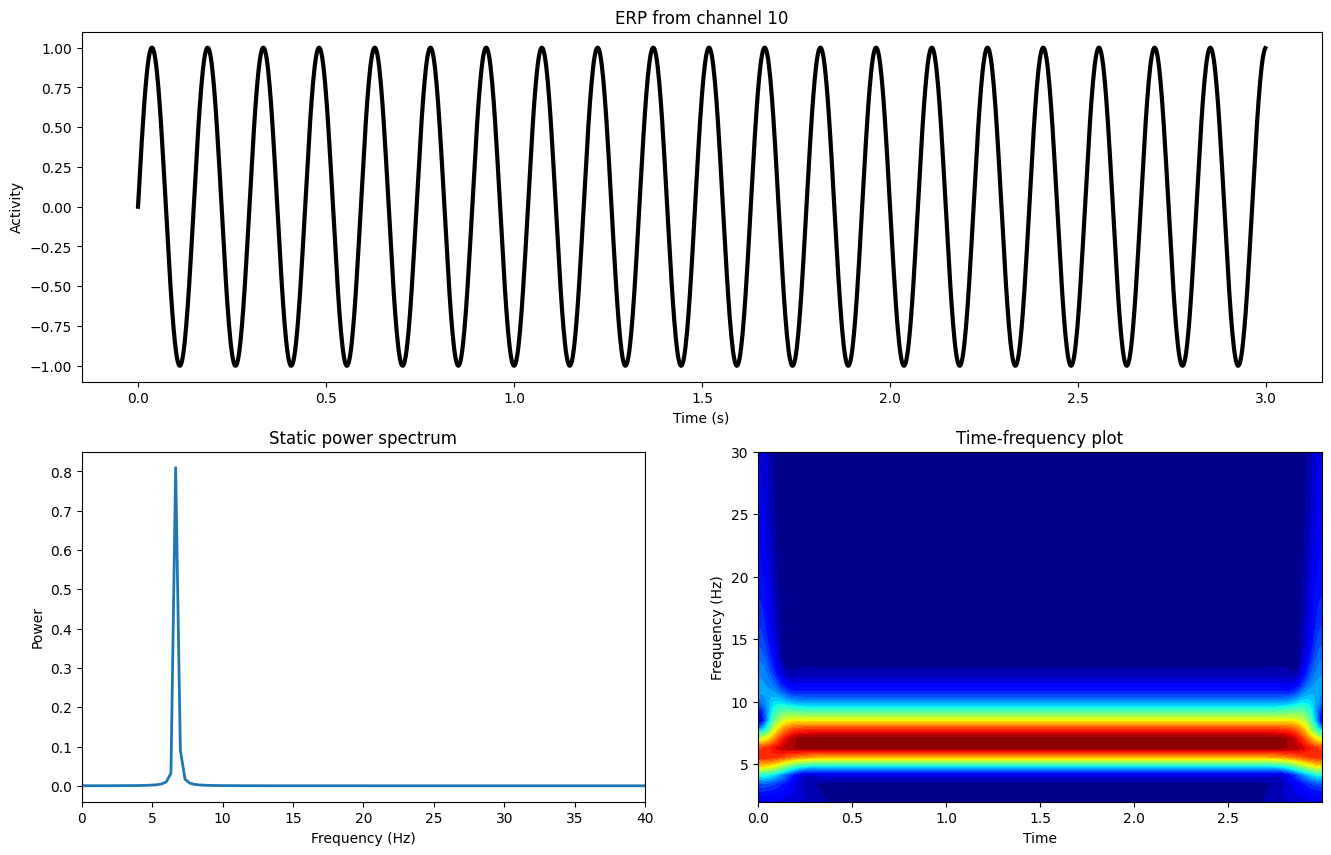

In [5]:
plot_simEEG(EEG, 10, 1)

## 2) Non-phase-locked sine wave

*Hint:* copy/paste the code above but add something inside the sine function on each trial

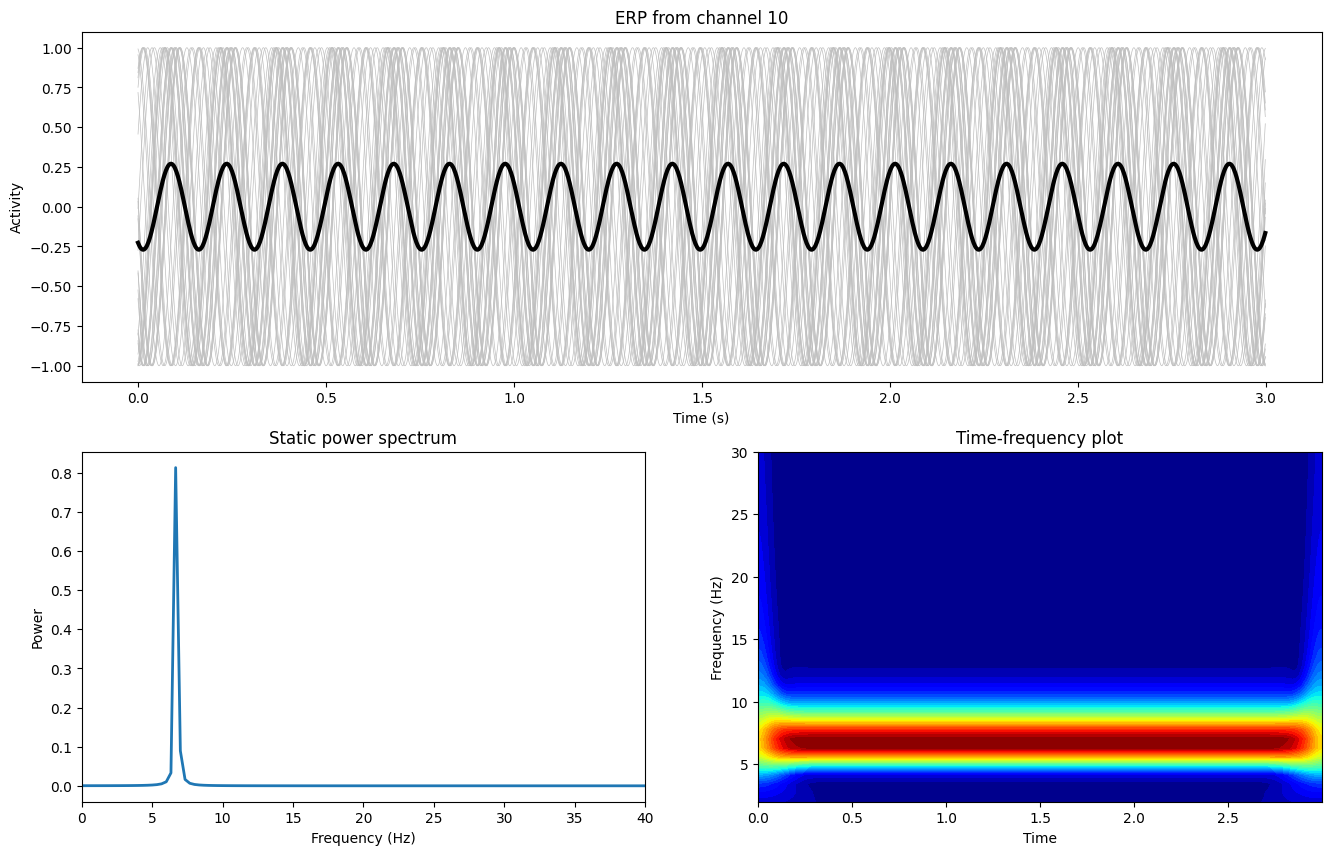

In [11]:
# loop over channels and create data
for chani in range(EEG.nbchan):
    for triali in range(EEG.trials):
        # data as a sine wave
        EEG.data[chani, :, triali] = np.sin(2*np.pi*sinefreq*EEG.times + 2*np.pi*np.random.randn())
        
plot_simEEG(EEG, 10, 1)

## 3) Multisine Waves

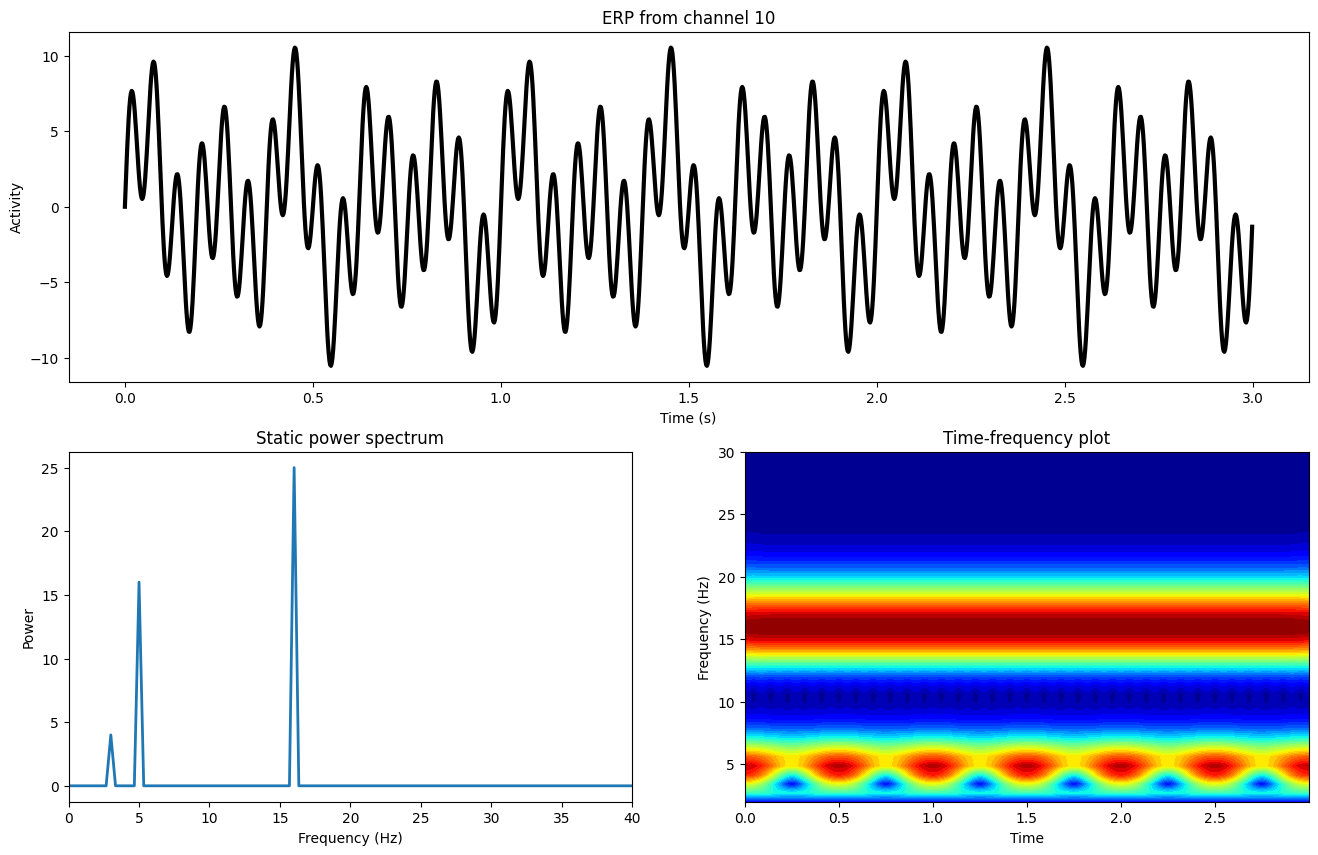

In [16]:
# list of frequencies and corresponding amplitudes
frex = [ 3, 5, 16 ]
amps = [ 2, 4, 5  ]

for chani in range(EEG.nbchan):
    for triali in range(EEG.trials):

        # hint copy code from sine wave lesson
        sinewave = np.zeros(EEG.times.shape)
        for fi in range(len(frex)):
            sinewave += amps[fi]*np.sin(2*np.pi*frex[fi]*EEG.times)
            #sinewave += amps[fi]*np.sin(2*np.pi*frex[fi]*EEG.times + 2*np.pi*np.random.uniform()) # comment the previous line and uncomment this line to see trial variability
        EEG.data[chani,:,triali] = sinewave
plot_simEEG(EEG, 10, 1)

## 4) Nonstationary sine waves

*Hint.* instantaneous frequency via interpolated random numbers

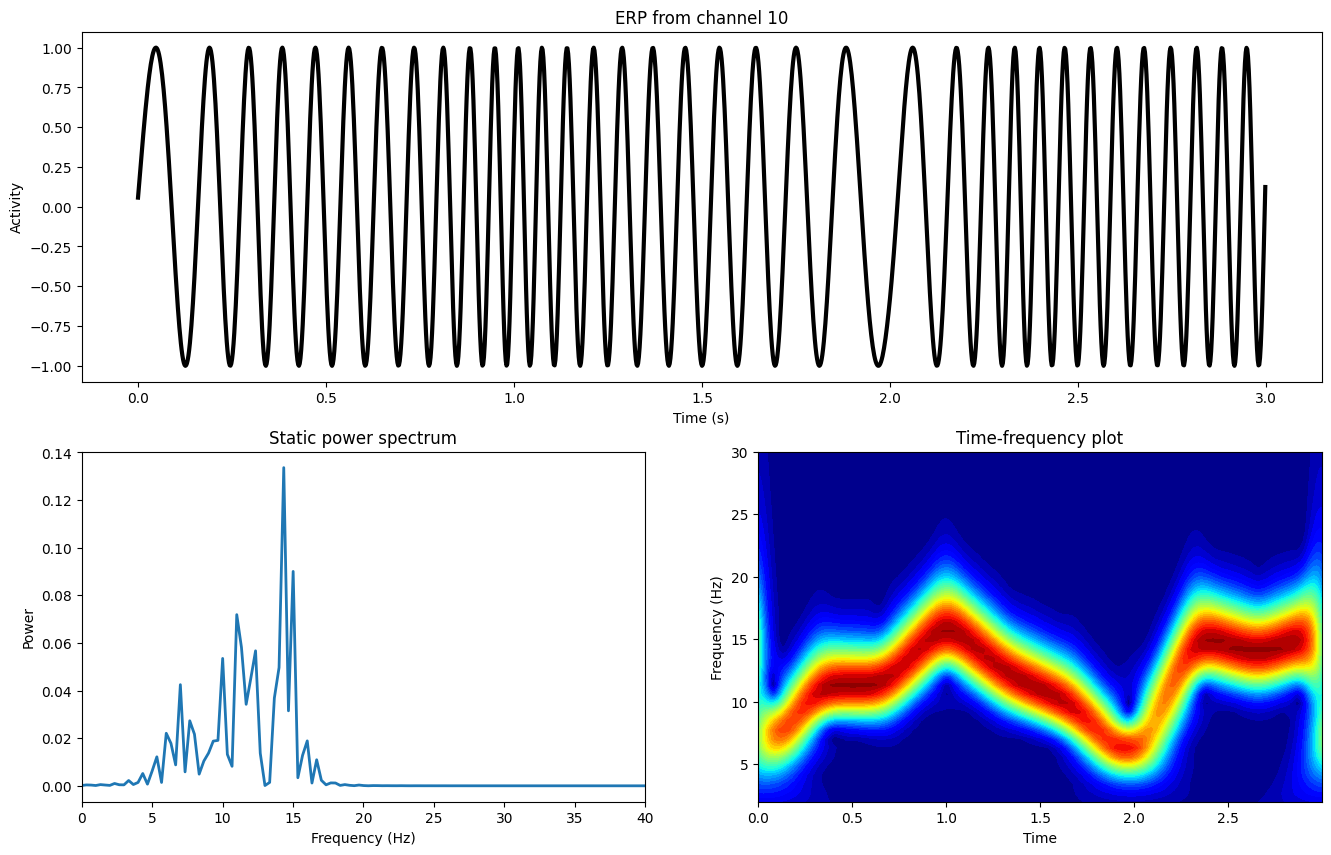

In [18]:
# freqmod = 20*interp1d(np.random.rand(10), np.linspace(1,10,EEG.pnts))
x = np.linspace(1, 10, 10)
y = np.random.rand(10)
f = interp1d(x, y)
xnew = np.linspace(1, 10, EEG.pnts)
freqmod = 20 * f(xnew)

for chani in range(EEG.nbchan):
    for triali in range(EEG.trials):
        signal  = np.sin( 2*np.pi * ((EEG.times + np.cumsum(freqmod))/EEG.srate) )
        EEG.data[chani, :, triali] = signal

plot_simEEG(EEG, 10, 1)

## 5) Transient oscillations w/ Gaussian

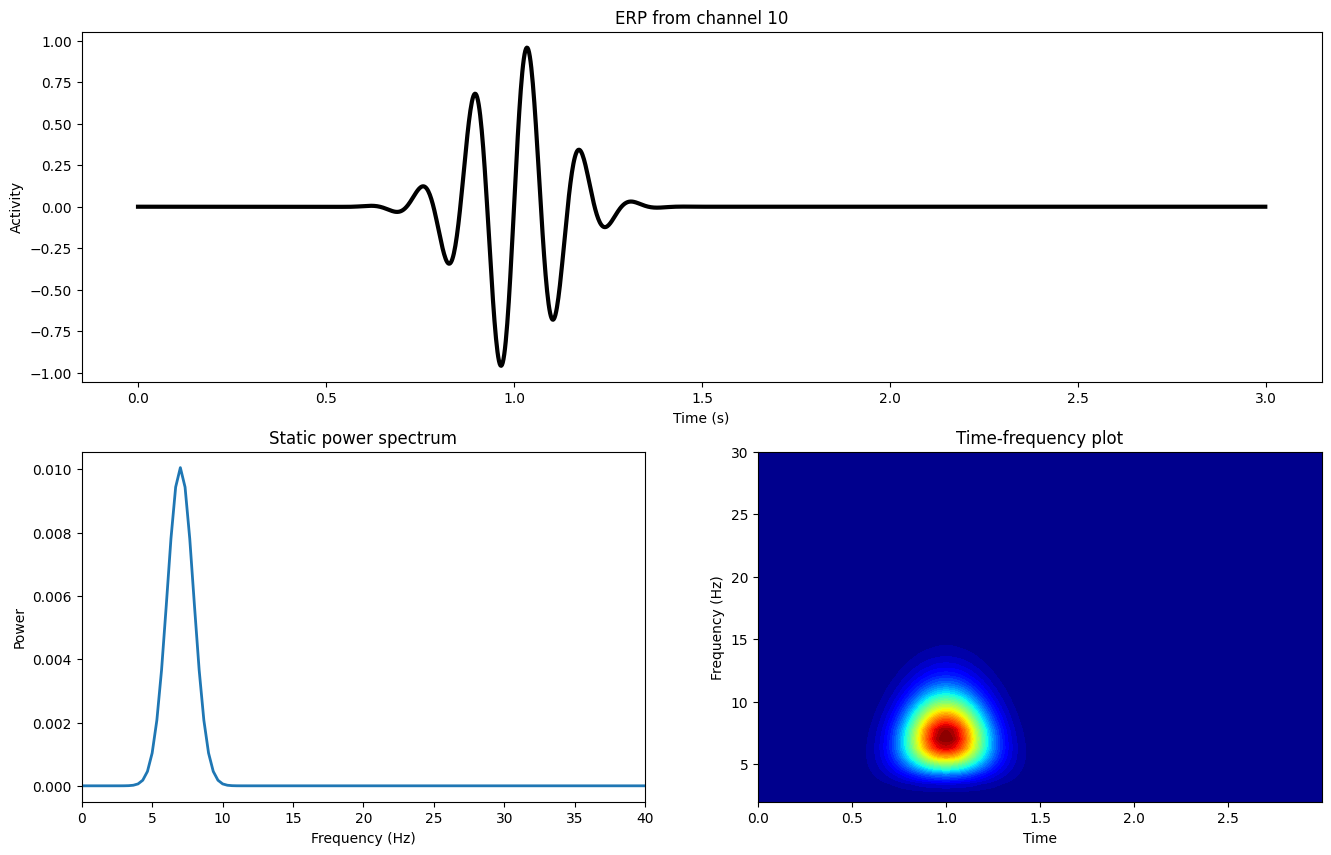

In [38]:
peaktime = 1 # seconds
width = .12
freq = 7 # for sine wave

# create gaussian taper
gaus = np.exp( -(EEG.times-peaktime)**2 / (2*width**2) )

# then, multiply the gaussian by a sine wave
for chani in range(EEG.nbchan):
    for triali in range(EEG.trials):
        
        # uncomment this gaussian if you want trial variability
        #gaus = np.exp( -(EEG.times-peaktime+np.random.randn()/5)**2 / (2*width**2) )

        sinewave = np.sin(2*np.pi*freq*EEG.times)
        #sinewave = np.sin(2*np.pi*freq*EEG.times + 2*np.pi*np.random.randn()) #uncomment to be non-phaselocked

        EEG.data[chani, :, triali] = sinewave * gaus

# and plot
plot_simEEG(EEG, 10, 1)

## 6) Repeat #3 with white noise

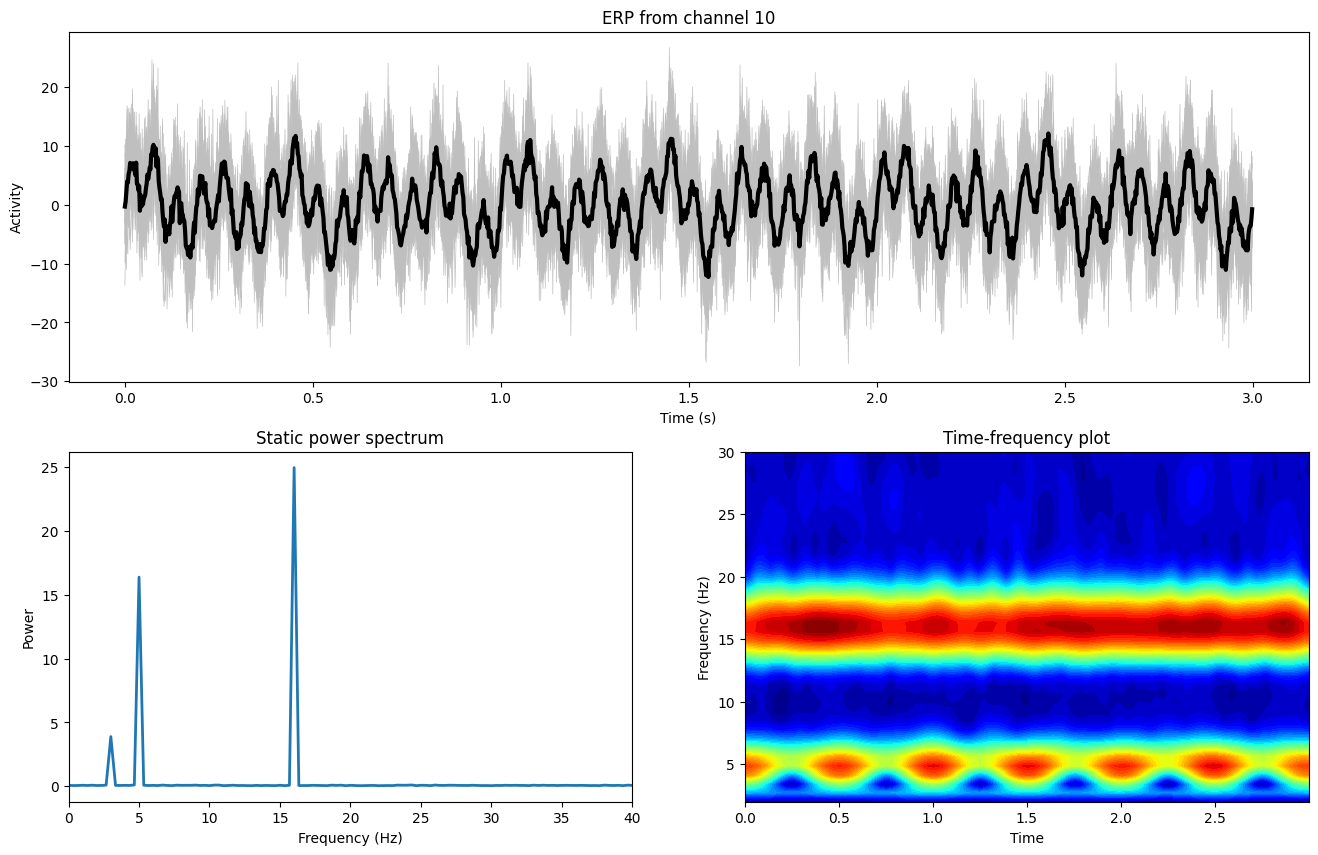

In [47]:
# list of frequencies and corresponding amplitudes
frex = [ 3, 5, 16 ]
amps = [ 2, 4, 5  ]

for chani in range(EEG.nbchan):
    for triali in range(EEG.trials):

        # hint copy some of the previous code
        sinewave = np.zeros(EEG.times.shape)
        for fi in range(len(frex)):
            sinewave += amps[fi]*np.sin(2*np.pi*frex[fi]*EEG.times)
            #sinewave += amps[fi]*np.sin(2*np.pi*frex[fi]*EEG.times + 2*np.pi*np.random.uniform())  # uncomment to add random variance      
        EEG.data[chani,:,triali] = sinewave +5*np.random.normal(size=EEG.times.shape)


plot_simEEG(EEG, 10, 1)

## 7) Repeat #5 with 1/f noise

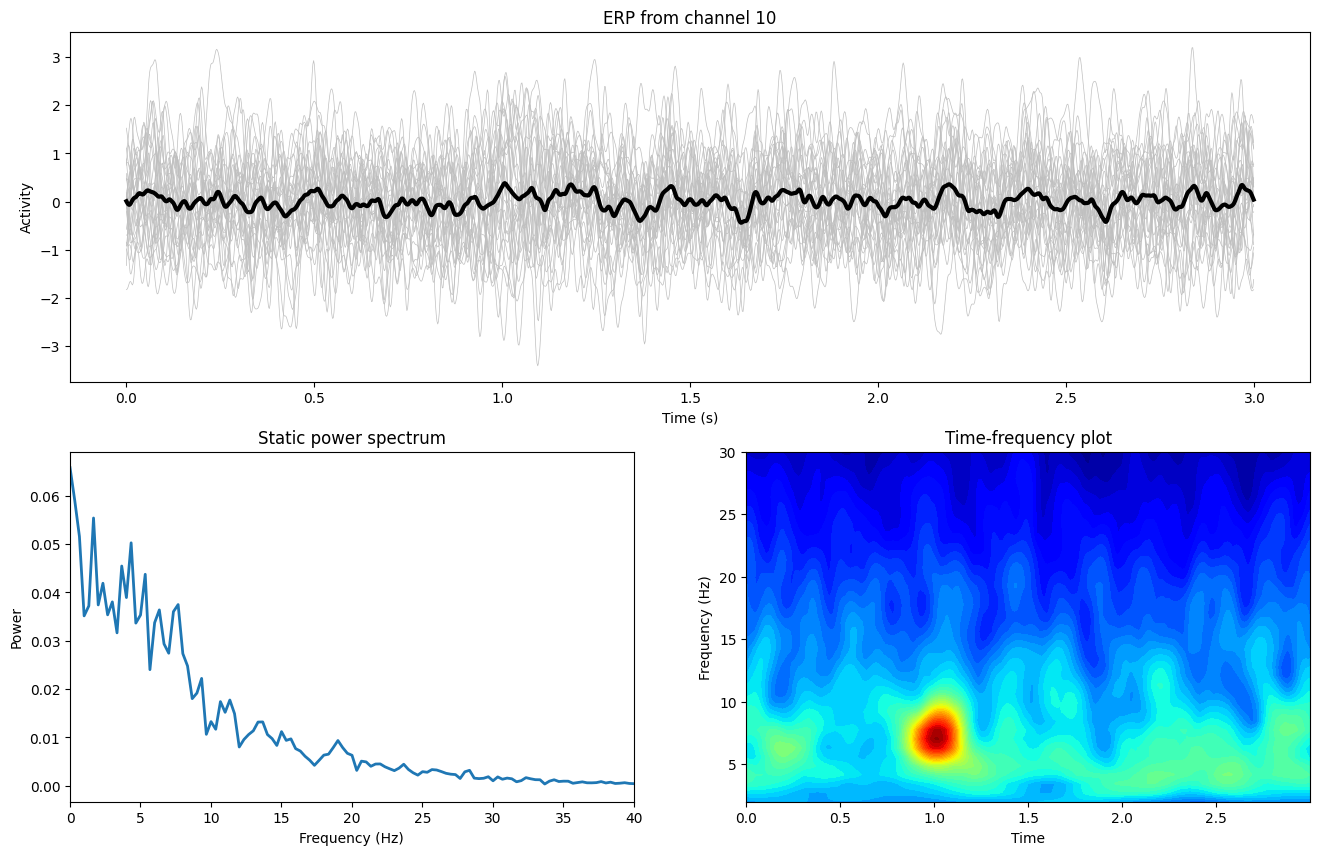

In [63]:
noiseamp = .3 # amount of noise
peaktime = 1 # seconds
width = .12
freq = 7

# create guassian taper
gaus = np.exp( -(EEG.times-peaktime)**2 / (2*width**2) )

for chani in range(EEG.nbchan):
    for triali in range(EEG.trials):
        cosw = np.cos(2*np.pi*freq*EEG.times + 2*np.pi*np.random.uniform() )
        
        #  generate 1/f amplitude spectrum
        ed = 50
        as_ = np.squeeze(np.random.rand(1, int(EEG.pnts/2) - 1) * np.exp(-(np.arange(1, int(EEG.pnts/2)))/ed))
        as_ = np.concatenate(([as_[0]], as_, [0], as_[::-1]))
        
        # Fourier coefficients
        fc = as_ * np.exp(1j * 2 * np.pi * np.random.rand(as_.shape[0]))

        noise = np.real(ifft(fc)) * EEG.pnts
        EEG.data[chani, :, triali] = (cosw*gaus) + (noiseamp*noise)
plot_simEEG(EEG, 10, 1)